# Data Processing, Exploratory Data Analysis, and Feature Engineering

In [ ]:
!pip install holidays

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import holidays

## Dataset

In [ ]:
path = '/content/drive/MyDrive/Product Sales Forecasting/data/'

sales = pd.read_csv(path + 'daily_prod_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.set_index('date')

In [ ]:
sales

,qty,base_price
date,,
2018-01-01,0.0,22
2018-01-02,5.0,22
2018-01-03,0.0,22
2018-01-04,6.0,22
2018-01-05,1.0,22
...,...,...
2025-05-28,6.0,27
2025-05-29,2.0,27
2025-05-30,3.0,27


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2709 entries, 2018-01-01 to 2025-06-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   qty         2660 non-null   float64
 1   base_price  2709 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 63.5 KB


In [ ]:
sales.describe()

,qty,base_price
count,2660.000000,2709.000000
mean,5.909398,24.966039
std,4.385056,2.130602
min,0.000000,22.000000
25%,3.000000,23.000000
50%,5.000000,27.000000
75%,8.000000,27.000000
max,36.000000,27.000000


In [ ]:
print('Unique qty values:', sales['qty'].sort_values().unique())
print()
print('Unique base_price values:', sales['base_price'].unique())

Unique qty values: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 29. 31. 33. 36. nan]

Unique base_price values: [22 23 24 27]


In [ ]:
# Get list of dates with missing qty value
print("Dates with null qty:", sales[sales['qty'].isna()].index)

Dates with null qty: DatetimeIndex(['2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
               '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
               '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02',
               '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07'],
              dtype='datetime64[ns]', name='date', freq=None)


## Data Cleaning

During the COVID-19 pandemic, California implemented a "stay at home" order, requiring non-essential services to close. This order forced the store to close from March 20 to May 7, 2020. The store was able to reopen on May 8 when the lockdown was partially lifted for certain businesses including clothing stores. As a result, dates during this period (03-20-2020 to 05-07-2020) have missing data and thus are indicate by null 'qty' values.

Simply imputing 0 is inappropriate as while it is technically true that there were no sales during this period, it is not because of low demand for the product. This will also cause issues with lag and rolling window features that depend on past values.

For the lockdown period, I imputed the median of the values from 357, 364, and 371 days prior, multiplied by the ratio of the sum of qtys 28 days (4 weeks) before and after the lockdown period to that of the corresponding days (364 days prior) from 2019, and rounded to the nearest integer.

Note: The store is closed on Christmas and New Year's Day. These days have 0 qty in the dataset but may skew the data and should be handled appropriately (e.g. if the model allows for missing dates, we might remove rows for these dates).

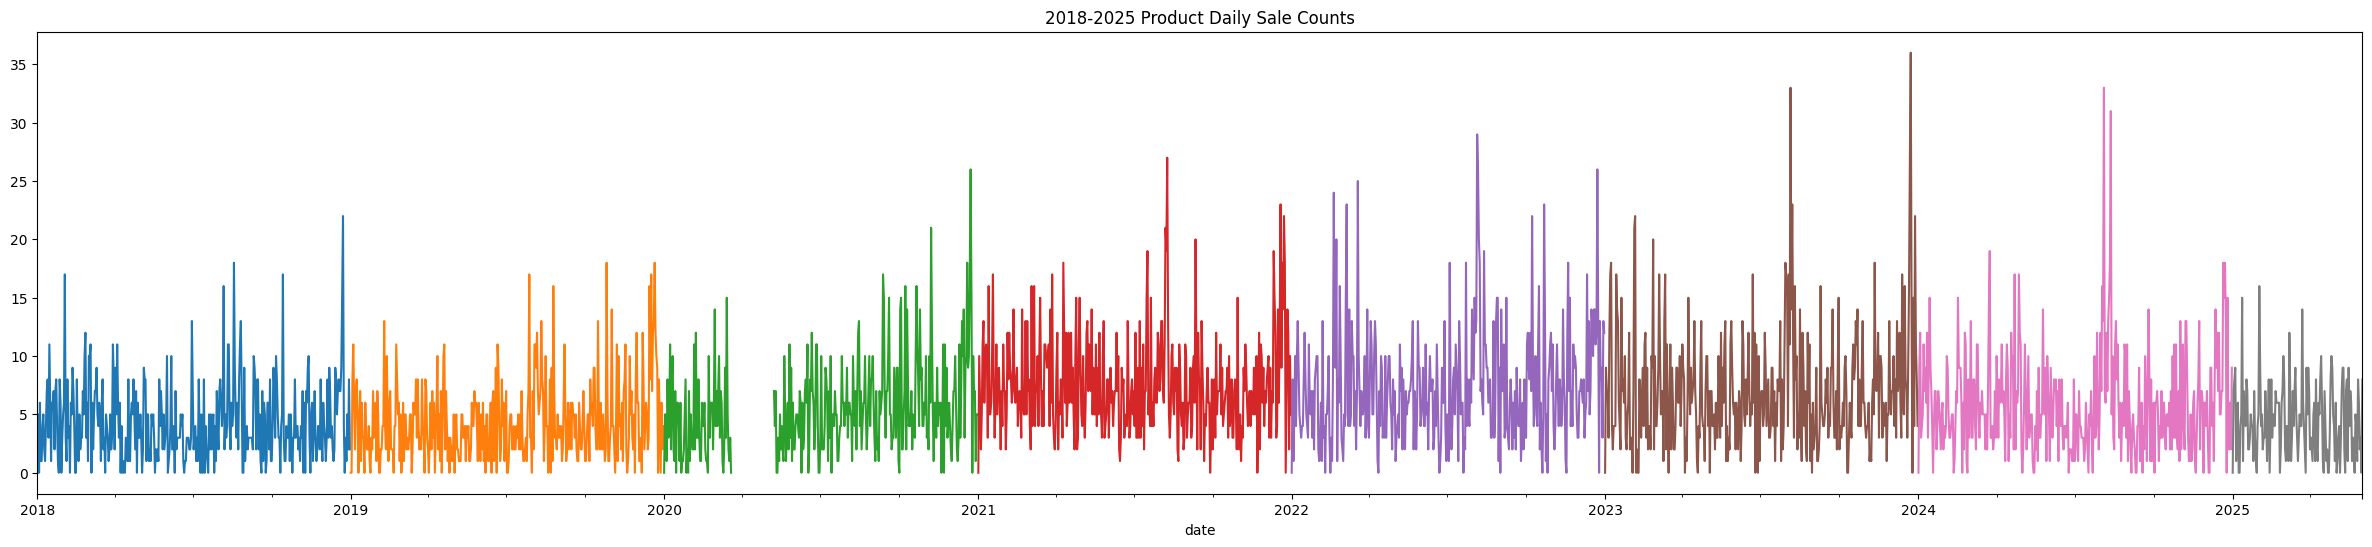

In [ ]:
# Plot qty during 2018-2021
for year in range(2018, 2026):
  sales.loc[str(year)]['qty'].plot(title=f'2018-2025 Product Daily Sale Counts', figsize=(30, 6), label=year)
plt.show()

Year effect multiplier = 1.1441441441441442


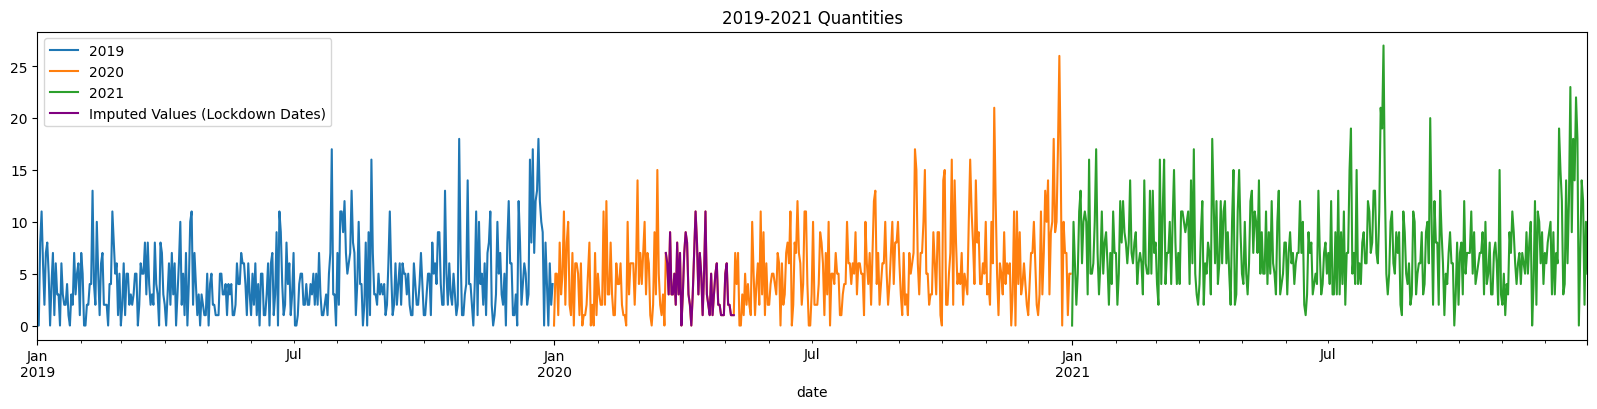

In [ ]:
sales_cleaned = sales.copy()

# Get range of lockdown dates and surrounding context dates
lockdown_dates = (sales_cleaned.index >= '2020-03-20') & (sales_cleaned.index <= '2020-05-07')
context_dates = (sales_cleaned.index >= '2020-02-21') & (sales_cleaned.index <= '2020-06-04') & ~lockdown_dates # 4 weeks before and after lockdown date range

# Compute year effect multiplier
shift_357 = sales_cleaned['qty'].shift(357)
shift_364 = sales_cleaned['qty'].shift(364)
shift_371 = sales_cleaned['qty'].shift(371)
year_effect = sales_cleaned[context_dates]['qty'].sum() / shift_364[context_dates].sum()
print(f"Year effect multiplier = {year_effect}")

# Get median of qty from 357, 364, and 371 days prior
imputer = pd.concat([shift_357, shift_364, shift_371], axis=1).median(axis=1)

# Multiply by year effect and round to nearest int
imputer *= year_effect
imputer = imputer.round()

# Impute values for lockdown dates
sales_cleaned.loc[lockdown_dates, 'qty'] = imputer.loc[lockdown_dates]

for year in range(2019, 2022):
  sales_cleaned.loc[str(year)]['qty'].plot(title=f'2019-2021 Quantities', figsize=(20, 4), label=year)
sales_cleaned.loc[lockdown_dates]['qty'].plot(color='purple', label='Imputed Values (Lockdown Dates)')
plt.legend()
plt.show()

## Add Date Features

- year
- month: 1 to 12 (January to December)
- week: 1 to 52 or 53
- day_of_week: 0 to 6 (Monday to Sunday)
- day_of_month: 1 to last day of respective month
- week_of_month: 1 to 4 or 5
- is_weekend: 1 if Saturday or Sunday, else 0
- is_holiday: 1 if US public holiday (from python holidays library), else 0

In [ ]:
sales_processed = sales_cleaned.copy()
sales_processed['year'] = sales_processed.index.year
sales_processed['month'] = sales_processed.index.month.astype('int8')
sales_processed['week'] = sales_processed.index.isocalendar().week.astype('int8')
sales_processed['day_of_week'] = sales_processed.index.dayofweek.astype('int8')
sales_processed['day_of_month'] = sales_processed.index.day.astype('int8')
sales_processed['week_of_month'] = sales_processed['day_of_month'].apply(lambda x: np.ceil(x/7)).astype('int8')
sales_processed['is_weekend'] = (sales_processed['day_of_week'] >= 5).astype('int8')

us_holidays = holidays.US(years=range(sales_processed['year'].iloc[0], sales_processed['year'].iloc[-1]))
sales_processed['is_holiday'] = sales_processed.index.isin(us_holidays).astype('int8')

sales_processed[sales_processed.index <= '2024-01-08'].tail(16)

<ipython-input-11-5a7003303119>:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  sales_processed['is_holiday'] = sales_processed.index.isin(us_holidays).astype('int8')


,qty,base_price,year,month,week,day_of_week,day_of_month,week_of_month,is_weekend,is_holiday
date,,,,,,,,,,
2023-12-24,13.0,27,2023,12,51,6,24,4,1,0
2023-12-25,0.0,27,2023,12,52,0,25,4,0,1
2023-12-26,15.0,27,2023,12,52,1,26,4,0,0
2023-12-27,4.0,27,2023,12,52,2,27,4,0,0
2023-12-28,22.0,27,2023,12,52,3,28,4,0,0
2023-12-29,11.0,27,2023,12,52,4,29,5,0,0
2023-12-30,8.0,27,2023,12,52,5,30,5,1,0
2023-12-31,4.0,27,2023,12,52,6,31,5,1,0
2024-01-01,0.0,27,2024,1,1,0,1,1,0,1


In [ ]:
sales_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2709 entries, 2018-01-01 to 2025-06-01
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   qty            2709 non-null   float64
 1   base_price     2709 non-null   int64  
 2   year           2709 non-null   int32  
 3   month          2709 non-null   int8   
 4   week           2709 non-null   int8   
 5   day_of_week    2709 non-null   int8   
 6   day_of_month   2709 non-null   int8   
 7   week_of_month  2709 non-null   int8   
 8   is_weekend     2709 non-null   int8   
 9   is_holiday     2709 non-null   int8   
dtypes: float64(1), int32(1), int64(1), int8(7)
memory usage: 92.6 KB


## Exploratory Data Analysis (EDA)

In [ ]:
# Get data starting from 2018 until before June 3, 2024 (training set)
mask = (sales_processed.index >= '2018-01-01') & (sales_processed.index < '2024-06-03')
sales_train = sales_processed[mask]

### KDE Plot of Target

Distribution of target is right skewed which might be an issue for linear or statistical models like ARIMA (not as much for tree-based models like LightGBM), so we'll consider using a transformation on the target with log, sqrt, or Box-Cox.

In [ ]:
# Find top 10 dates by qty
sales_train[['qty']].sort_values(by='qty', ascending=False).head(10)

,qty
date,
2023-12-23,36.0
2023-08-05,33.0
2022-08-05,29.0
2021-08-09,27.0
2023-12-22,27.0
2020-12-23,26.0
2022-08-06,26.0
2022-12-23,26.0
2022-03-19,25.0


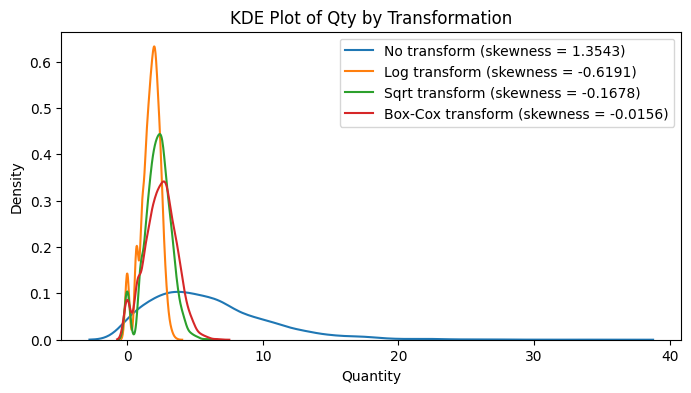

In [ ]:
from scipy.stats import skew, boxcox

plt.figure(figsize=(8, 4))

sns.kdeplot(sales_train['qty'], label=f"No transform (skewness = {skew(sales_train['qty']):.4f})")
sns.kdeplot(np.log1p(sales_train['qty']), label=f"Log transform (skewness = {skew(np.log1p(sales_train['qty'])):.4f})")
sns.kdeplot(np.sqrt(sales_train['qty']), label=f"Sqrt transform (skewness = {skew(np.sqrt(sales_train['qty'])):.4f})")
sns.kdeplot(boxcox(sales_train['qty'] + 1)[0], label=f"Box-Cox transform (skewness = {skew(boxcox(sales_train['qty'] + 1)[0]):.4f})")

plt.legend()
plt.title("KDE Plot of Qty by Transformation")
plt.xlabel("Quantity")
plt.ylabel("Density")
plt.show()

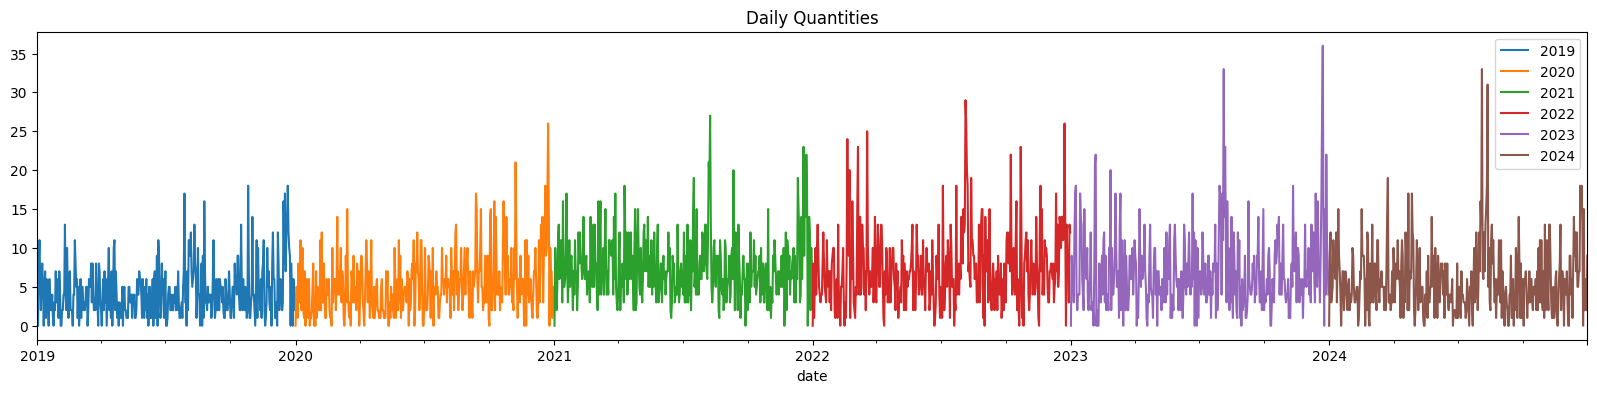

In [ ]:
#@title Plot Daily Quantity

for year in range(2019, 2025):
  sales_cleaned.loc[str(year)]['qty'].plot(title=f'Daily Quantities', figsize=(20, 4), label=year)
plt.legend()

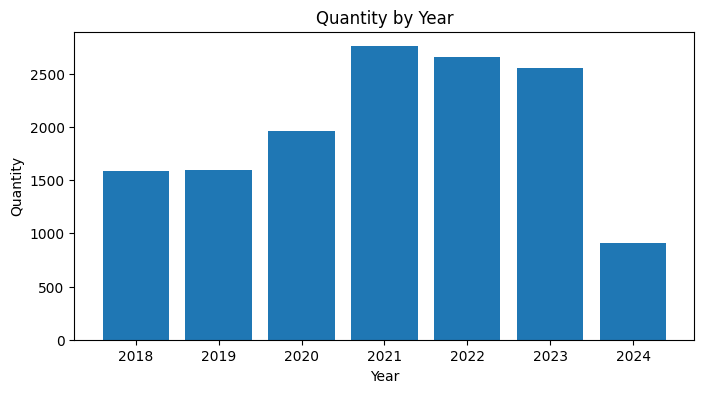

In [ ]:
#@title Plot Yearly Quantity Totals
sales_yearly = sales_train.groupby('year')['qty'].sum()

# Plot
plt.figure(figsize=(8, 4))
plt.bar(sales_yearly.index, sales_yearly.values)
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.title('Quantity by Year')
plt.show()

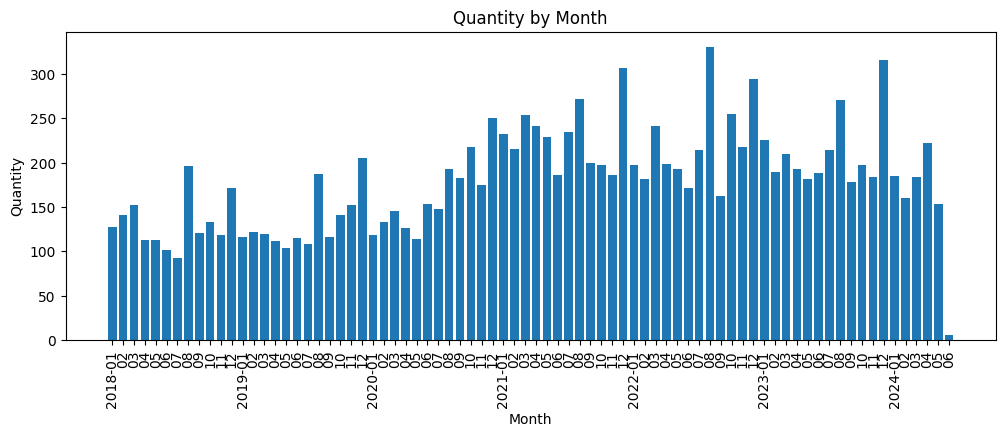

In [ ]:
#@title Plot Monthly Quantity Totals

sales_monthly = sales_train.copy()
sales_monthly = sales_monthly['qty'].resample('ME').sum()
sales_monthly.index = sales_monthly.index.to_period('M')

labels = [
  date.strftime('%Y-%m') if date.month == 1 else date.strftime('%m')
  for date in sales_monthly.index
]

plt.figure(figsize=(12, 4))
plt.bar(sales_monthly.index.astype(str), sales_monthly.values)
plt.xticks(ticks=sales_monthly.index.astype(str), labels=labels, rotation=90)
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.title('Quantity by Month')
plt.show()

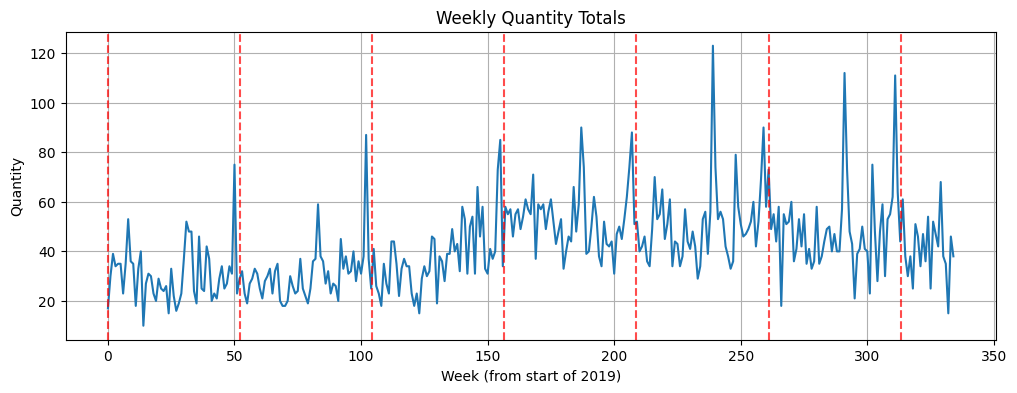

In [ ]:
#@title Plot Weekly Quantity Totals
sales_weekly = sales_train.copy()
sales_weekly = sales_weekly.reset_index(drop=True)
sales_weekly['week_group'] = np.floor(sales_weekly.index / 7).astype(int)
sales_weekly = sales_weekly.groupby('week_group')['qty'].sum()

plt.figure(figsize=(12, 4))
sales_weekly.plot(kind='line')
for i in np.arange(0, sales_weekly.shape[0], 52.2):
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.7)
plt.title('Weekly Quantity Totals')
plt.xlabel('Week (from start of 2019)')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

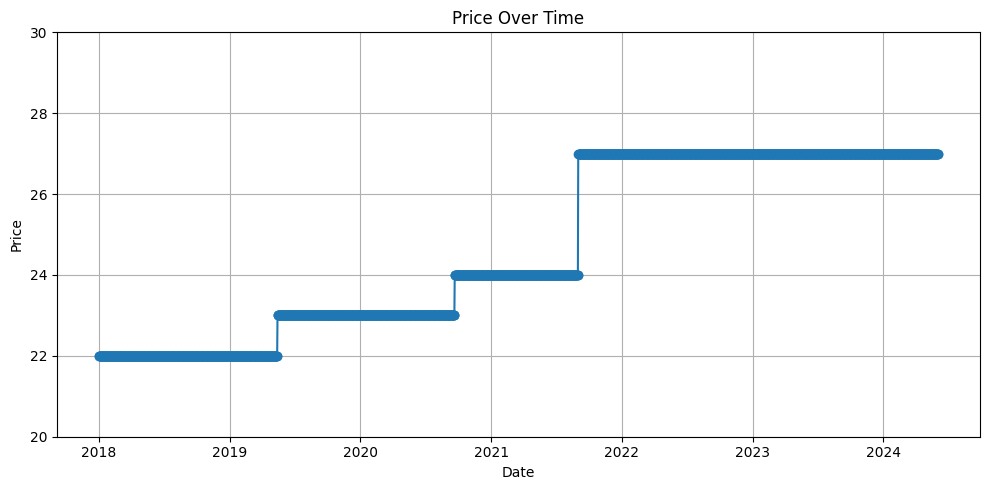

In [ ]:
# Plot Date vs Price
plt.figure(figsize=(10, 5))
plt.plot(sales_train.index, sales_train['base_price'], marker='o')
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.ylim(20, 30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#@title Check Stationarity

from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary (p_value < 0.05)' if p_value < 0.05 else 'Non-Stationary (p_value >= 0.05)')

check_stationarity(sales_train['qty'])

ADF Statistic: -5.172158707081894
p-value: 1.0018752214336273e-05
Stationary (p_value < 0.05)


## STL Decomposition (Seasonal-Trend Decomposition using Loess)

In [ ]:
from statsmodels.tsa.seasonal import STL

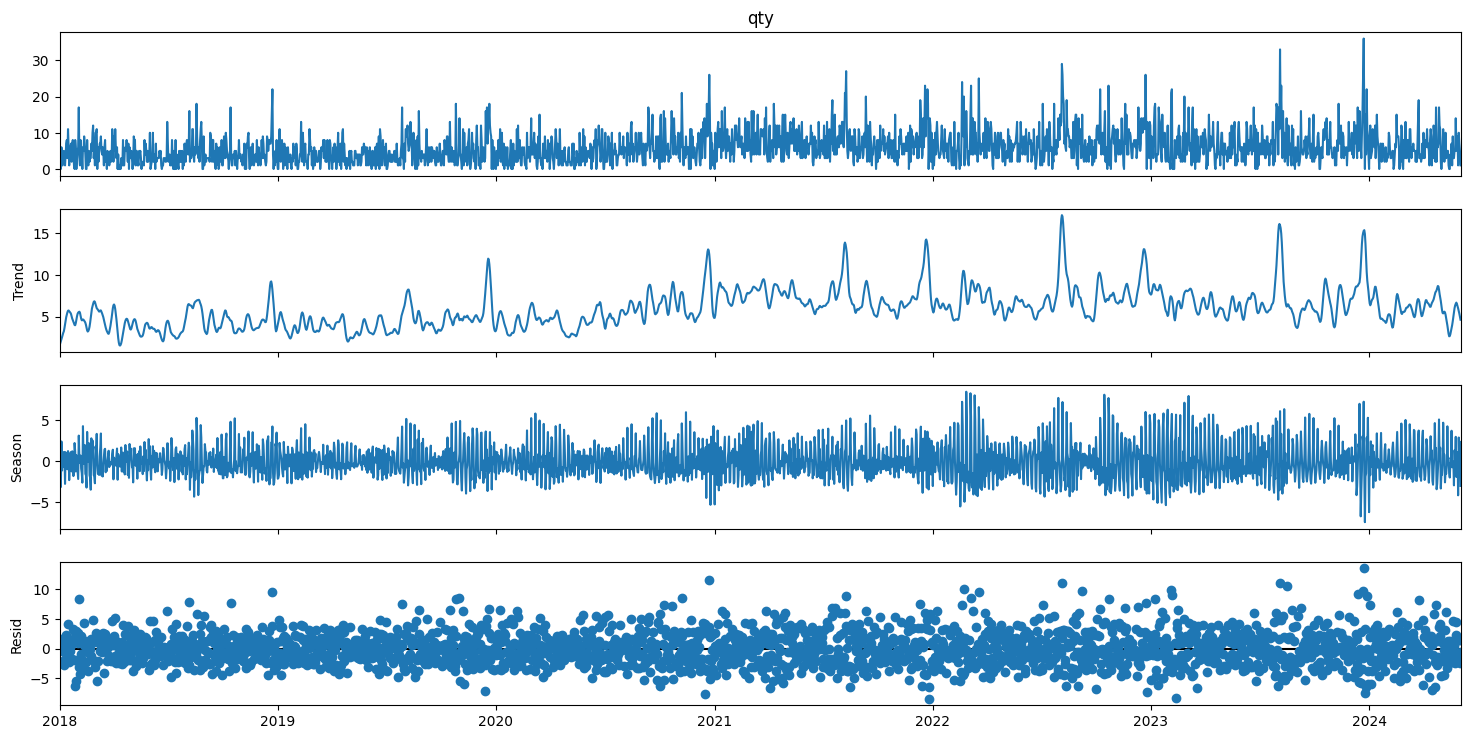

In [ ]:
#@title STL with Period = 7

stl_p7 = STL(sales_train['qty'], period=7)
res_p7 = stl_p7.fit()
res_p7.plot().set_size_inches(16, 8)

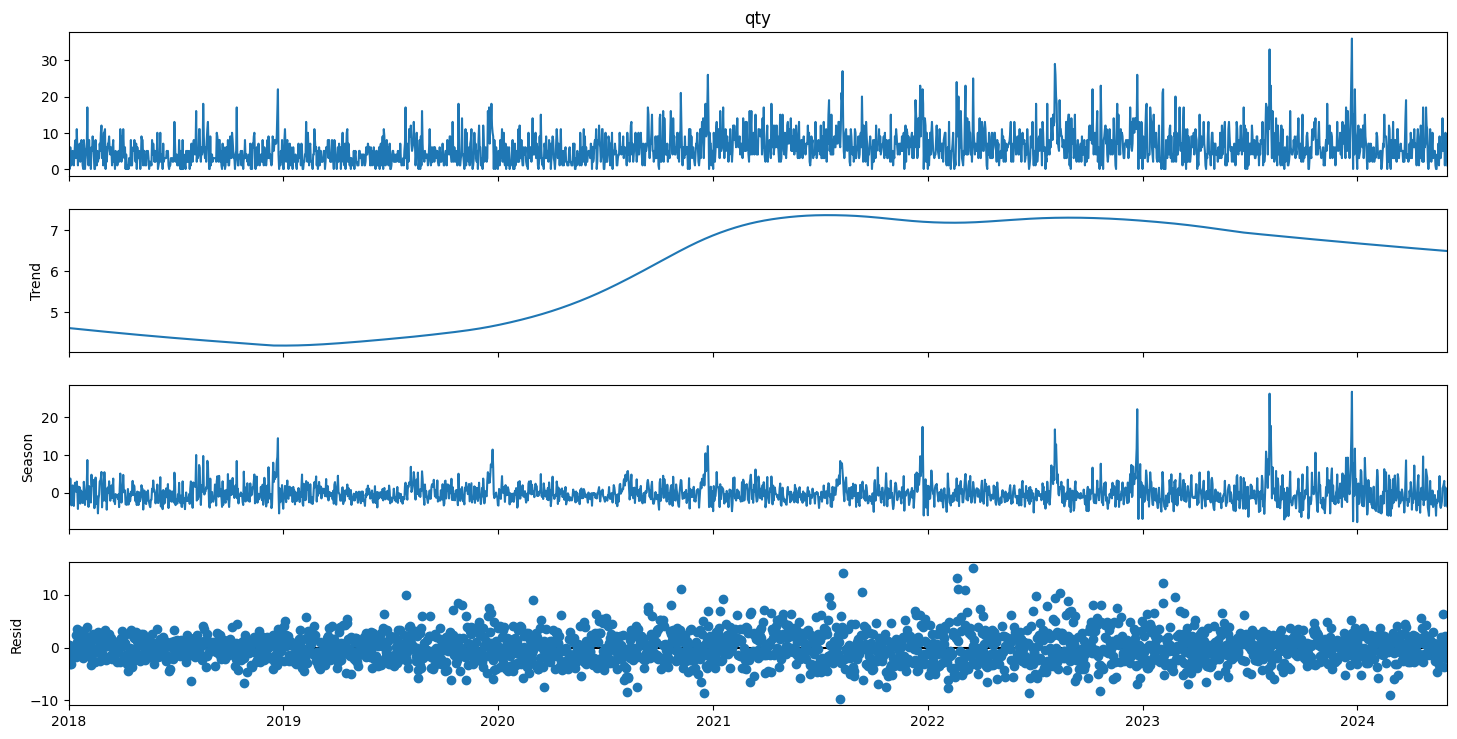

In [ ]:
#@title STL with Period = 365

stl_p365 = STL(sales_train['qty'], period=365)
res_p365 = stl_p365.fit()
res_p365.plot().set_size_inches(16, 8)

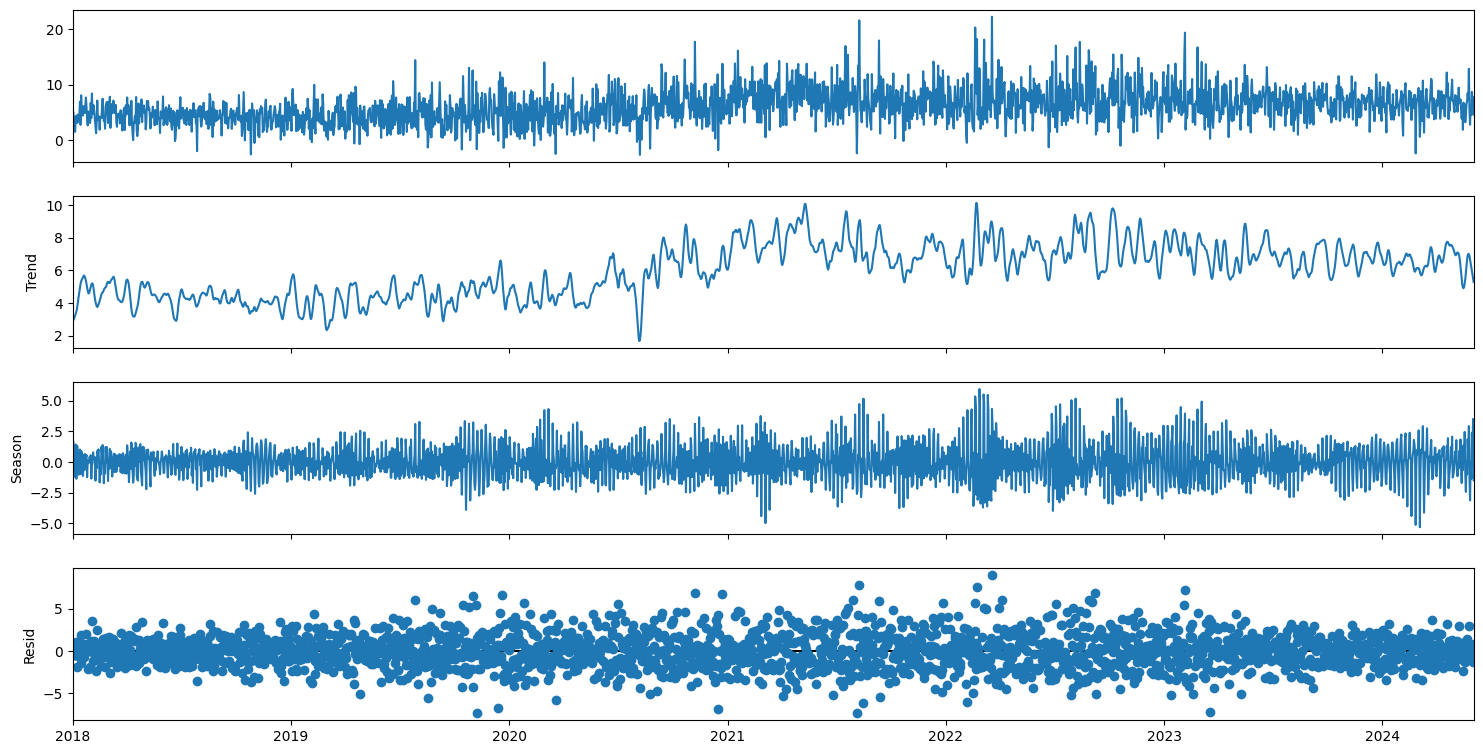

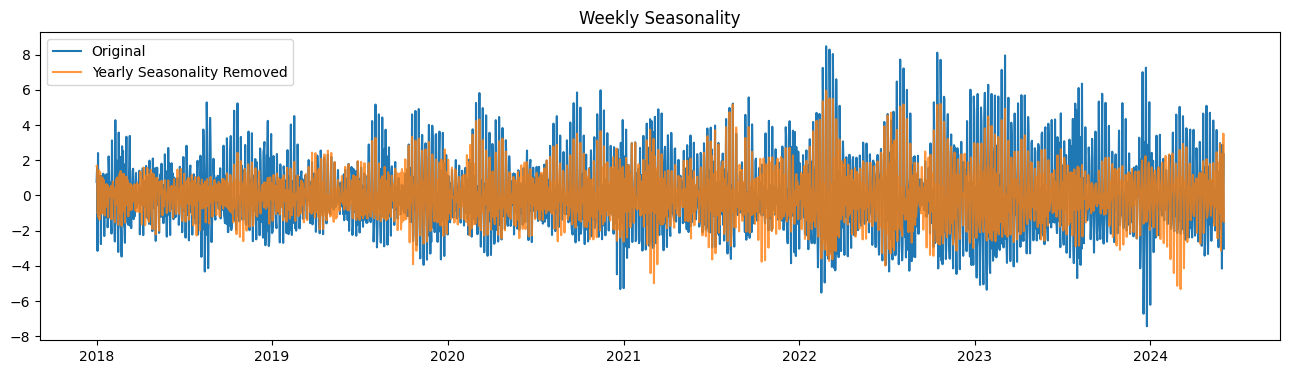

In [ ]:
#@title STL with Period = 7 and Yearly Seasonality Removed

deseasonalized = sales_train['qty'] - res_p365.seasonal

stl_p7_deseasonalized = STL(deseasonalized, period=7)
res_p7_deseasonalized = stl_p7_deseasonalized.fit()
res_p7_deseasonalized.plot().set_size_inches(16, 8)

plt.figure(figsize=(16, 4))
plt.plot(res_p7.seasonal, label='Original')
plt.plot(res_p7_deseasonalized.seasonal, label='Yearly Seasonality Removed', alpha=0.8)
plt.legend()
plt.title('Weekly Seasonality')
plt.show()

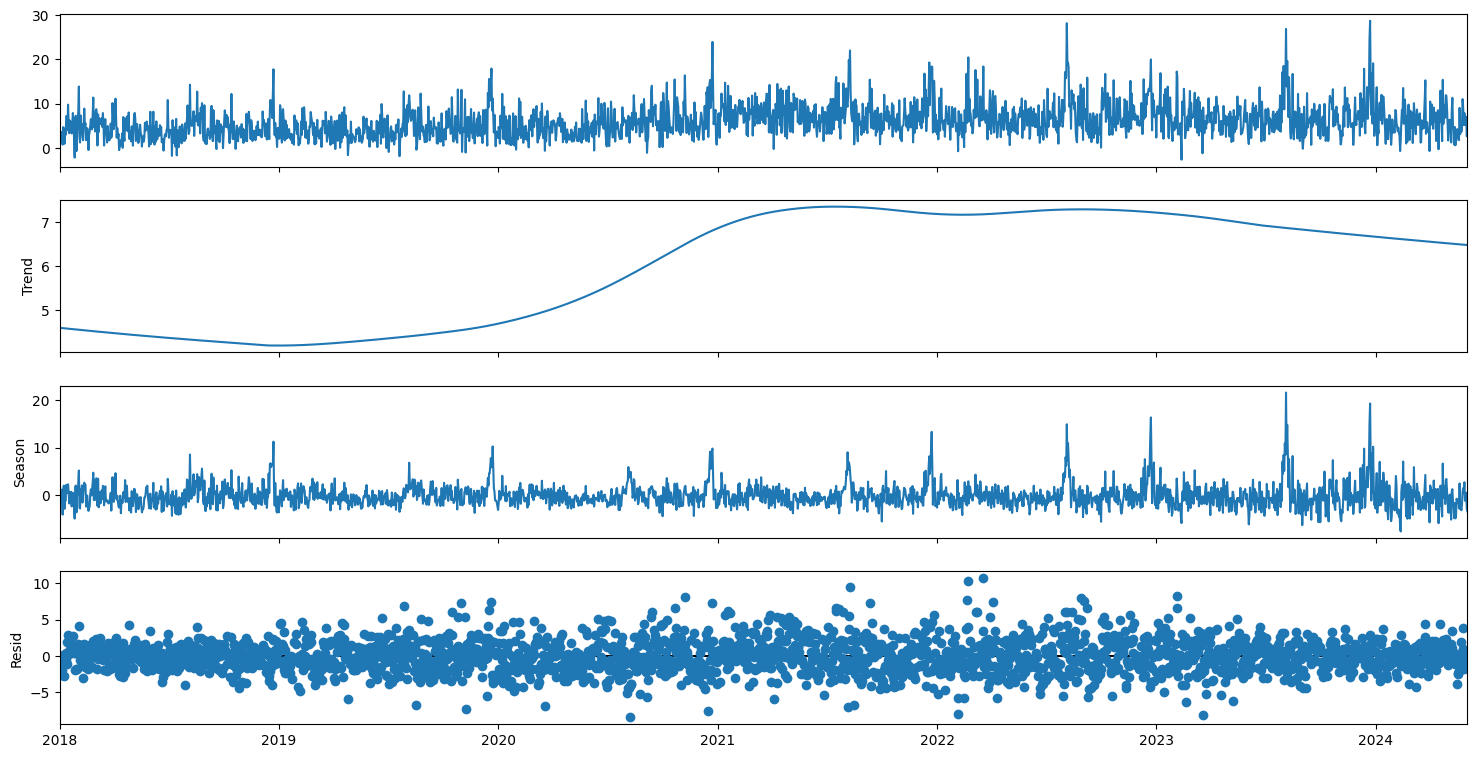

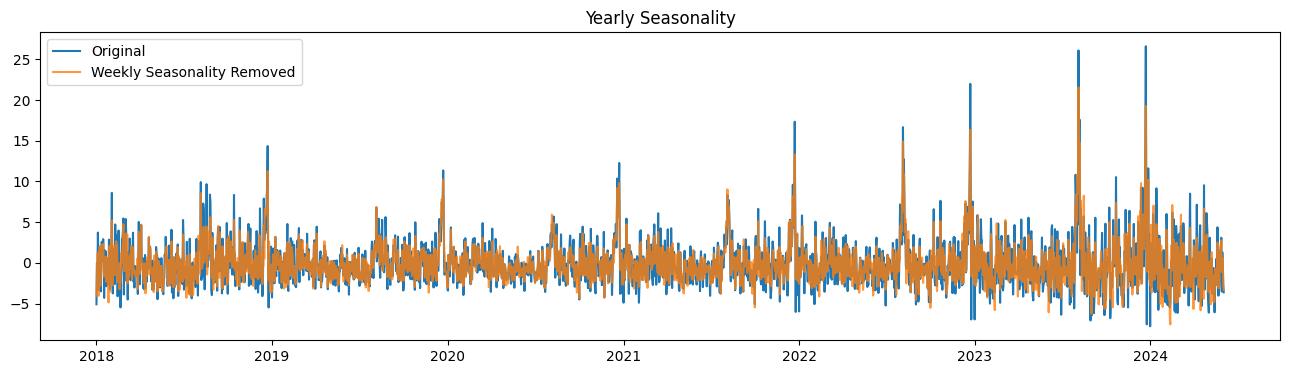

In [ ]:
#@title STL with Period = 365 and Weekly Seasonality Removed

deseasonalized_7 = sales_train['qty'] - res_p7.seasonal

stl_p365_deseasonalized = STL(deseasonalized_7, period=365)
res_p365_deseasonalized = stl_p365_deseasonalized.fit()
res_p365_deseasonalized.plot().set_size_inches(16, 8)

plt.figure(figsize=(16, 4))
plt.plot(res_p365.seasonal, label='Original')
plt.plot(res_p365_deseasonalized.seasonal, label='Weekly Seasonality Removed', alpha=0.8)
plt.legend()
plt.title('Yearly Seasonality')
plt.show()

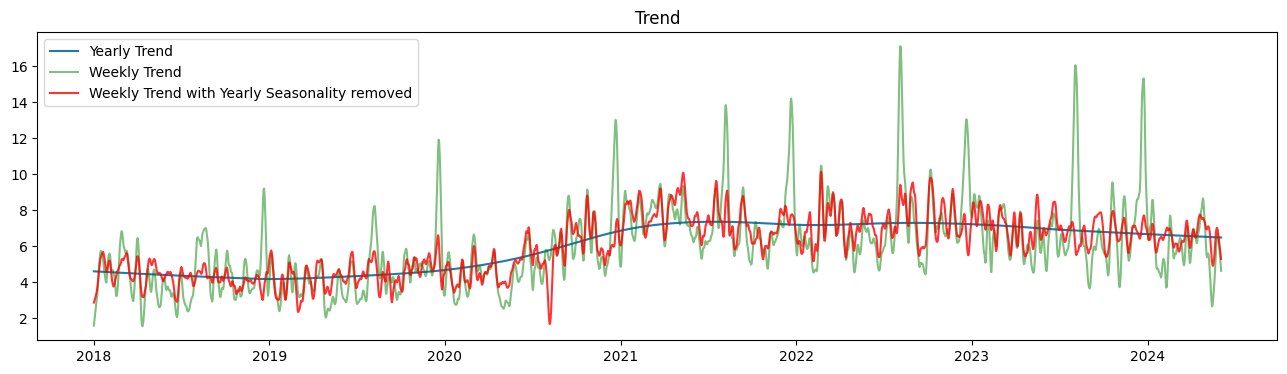

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(res_p365.trend, label='Yearly Trend')
plt.plot(res_p7.trend, label='Weekly Trend', alpha=0.5, color='green')
plt.plot(res_p7_deseasonalized.trend, label='Weekly Trend with Yearly Seasonality removed', alpha=0.8, color='red')

plt.legend()
plt.title('Trend')
plt.show()

## ACF and PACF Plots

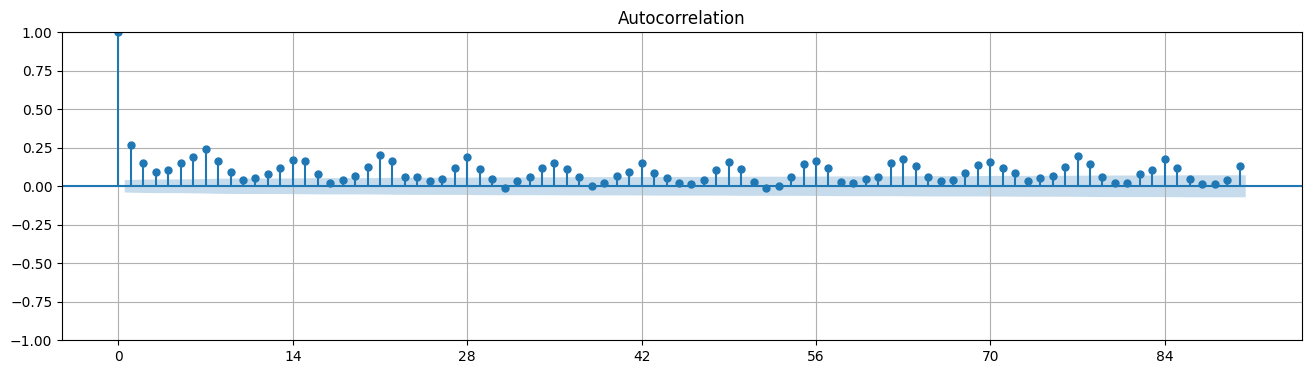

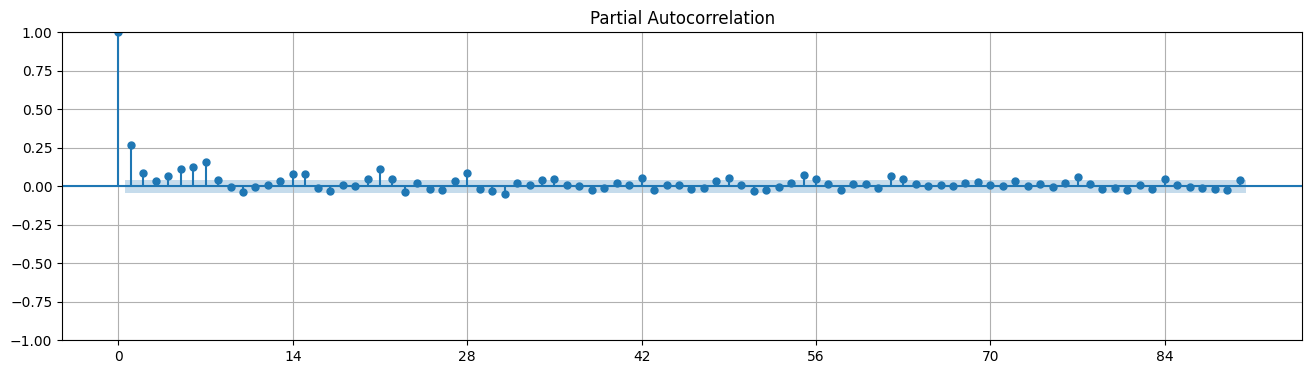

In [ ]:
# Plot ACF and PACF with 90 lags

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(16, 4))
plot_acf(sales_train['qty'], lags=90, ax=ax)
ax.set_xticks(range(0, 91, 14))
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
plot_pacf(sales_train['qty'], lags=90, ax=ax)
ax.set_xticks(range(0, 91, 14))
plt.grid()
plt.show()

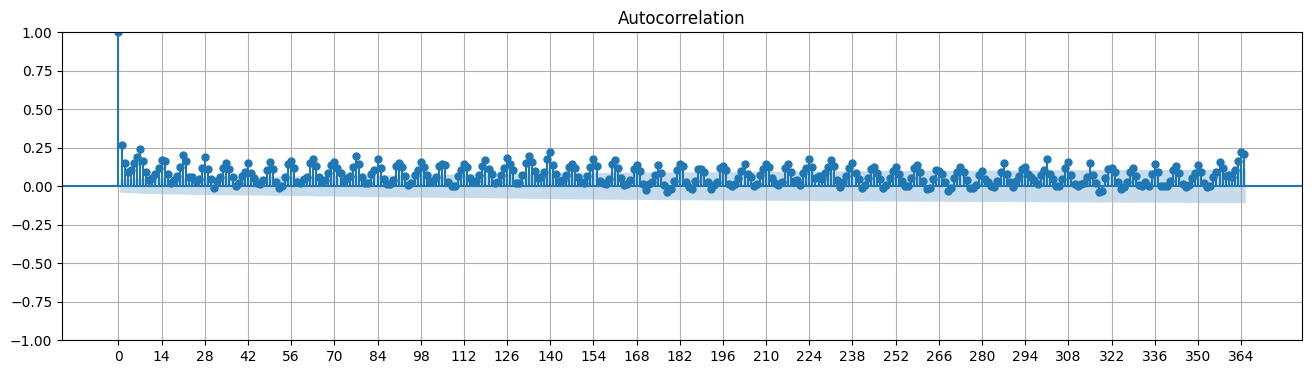

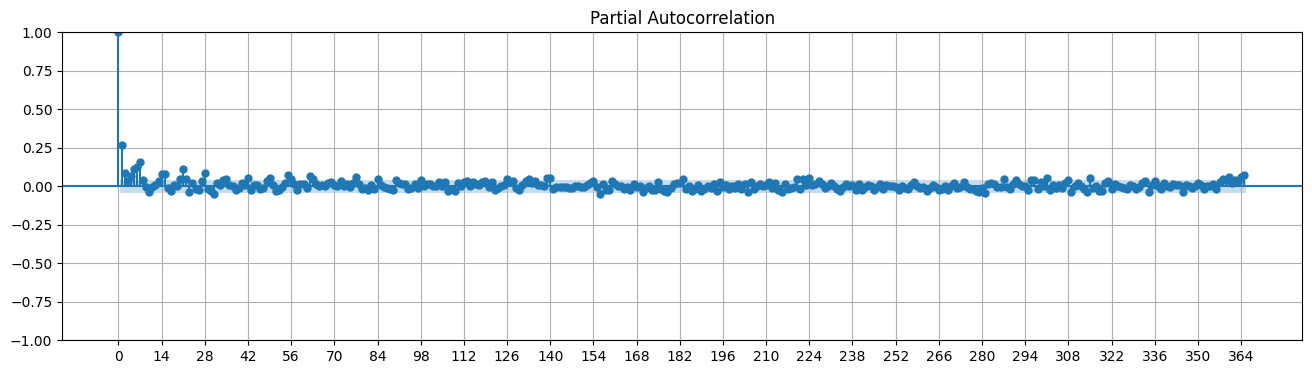

In [ ]:
# Plot ACF and PACF with 365 lags

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(16, 4))
plot_acf(sales_train['qty'], lags=365, ax=ax)
ax.set_xticks(range(0, 366, 14))
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
plot_pacf(sales_train['qty'], lags=365, ax=ax)
ax.set_xticks(range(0, 366, 14))
plt.grid()
plt.show()

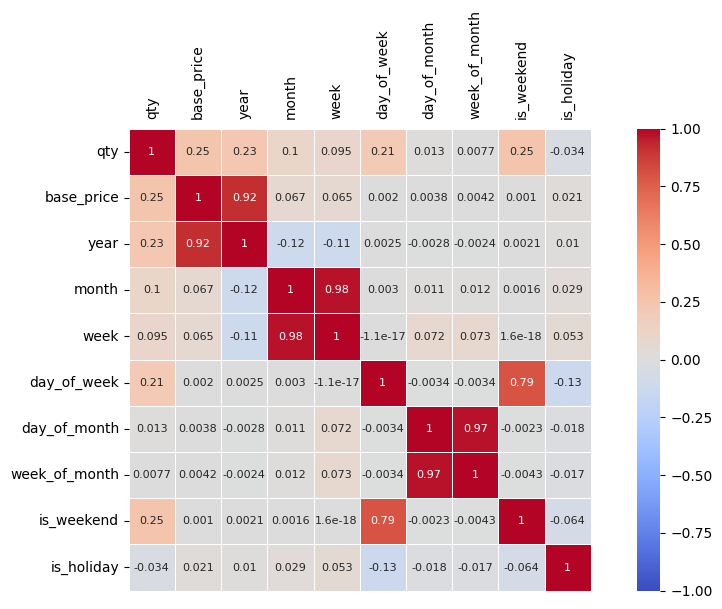

In [ ]:
#@title Correlation Matrix Heatmap
plt.figure(figsize=(12, 6))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top=False, labeltop=True)
heatmap = sns.heatmap(sales_train.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":8}, linewidth=.5, square=True, cmap="coolwarm")

In [ ]:
#@title Make boxplots for column, optionally grouped by another column
def boxplot(df, col, group=None):
  title = f"Quantity vs. {col.capitalize()}"
  plt.figure(figsize=(12, 4))

  if group == None:
    sns.boxplot(data=df, x=col, y='qty', hue=col, palette='tab10')
    plt.legend().remove()
  else:
    sns.boxplot(data=df, x=col, y='qty', hue=group, palette='tab10')
    title += f" (grouped by {group.capitalize()})"
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

  plt.title(title)
  plt.show()

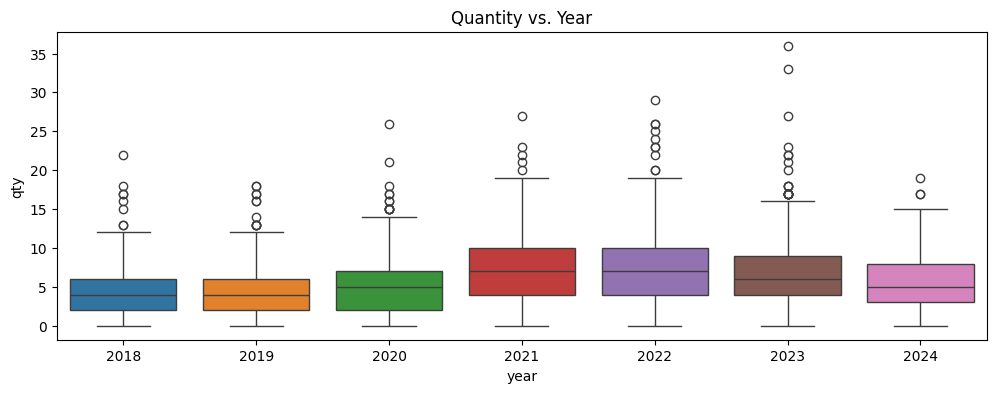

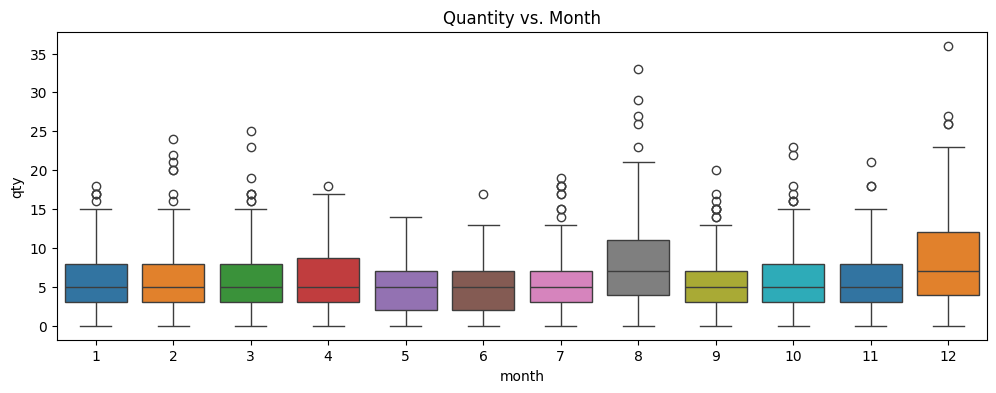

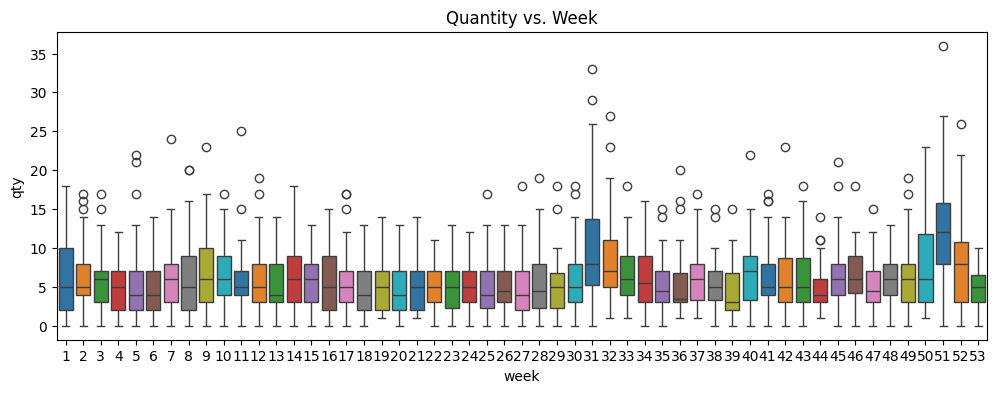

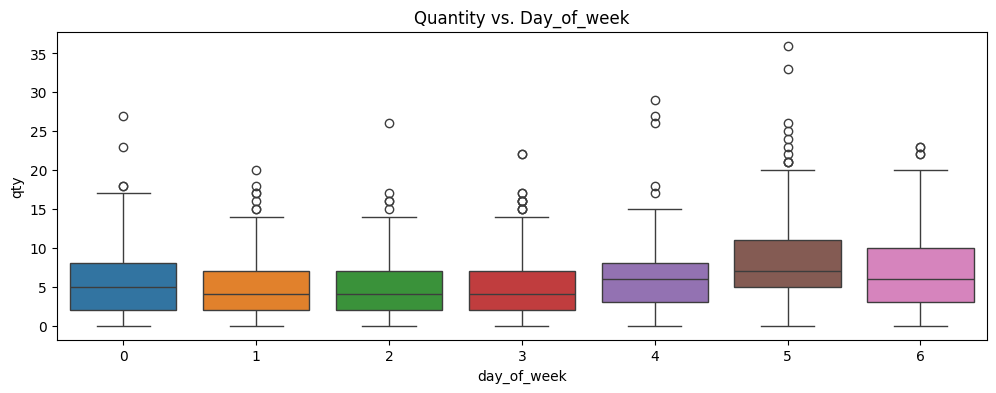

In [ ]:
# Boxplot for Quantity vs. each column in cols
cols = ['year', 'month', 'week', 'day_of_week']
for col in cols:
  boxplot(sales_train, col)

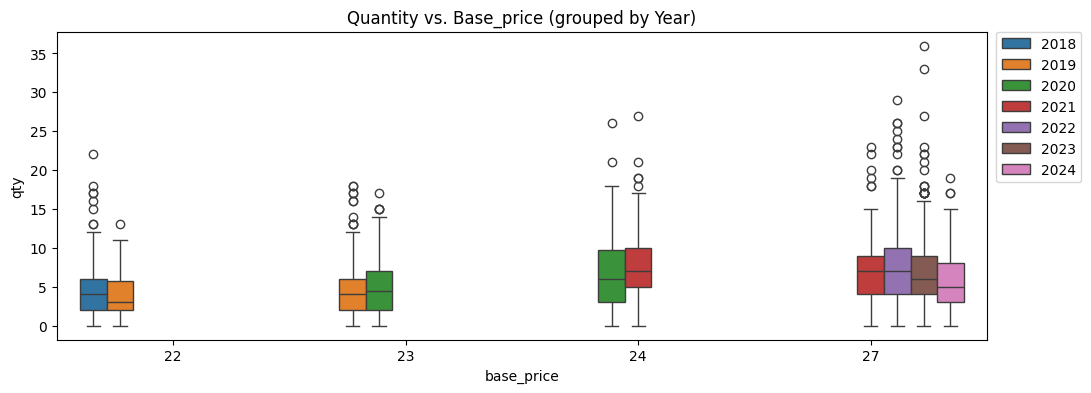

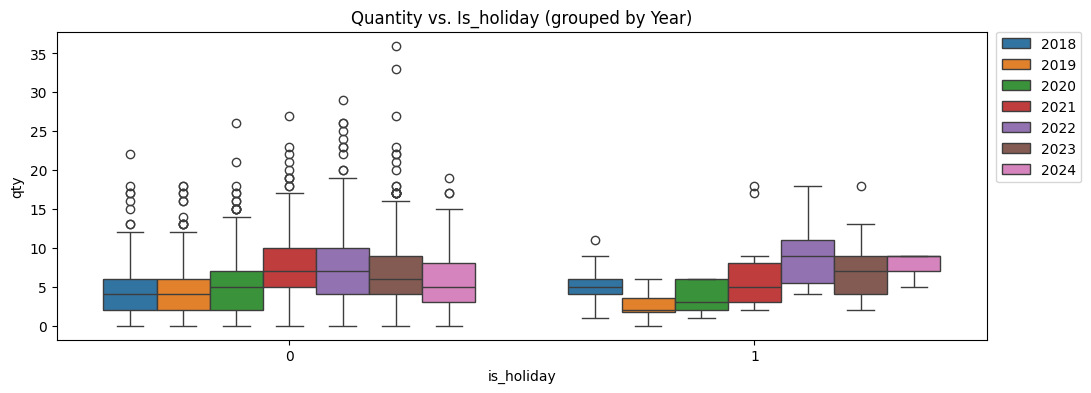

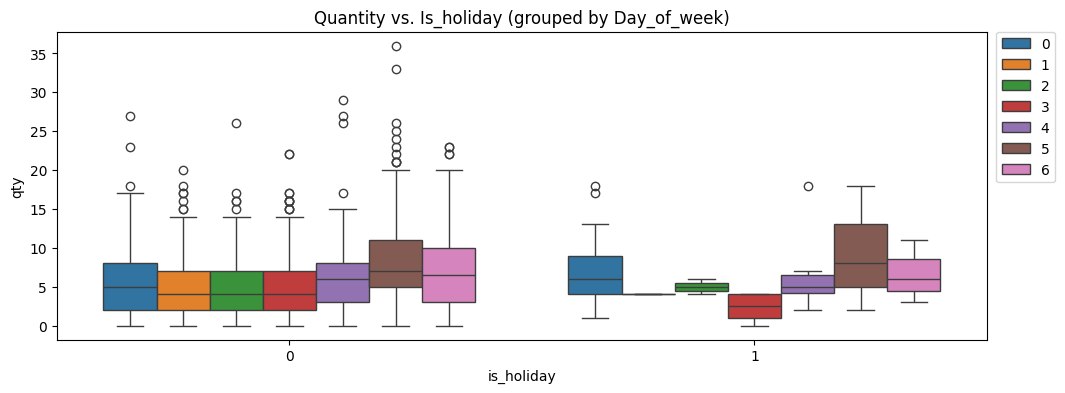

In [ ]:
# Boxplot for Quantity vs. Base Price grouped by year
boxplot(sales_train, 'base_price', 'year')

# Boxplot for Quantity vs. is_holiday grouped by year/day_of_week, not including closed days
christmas = (sales_train['month'] == 12) & (sales_train['day_of_month'] == 25)
new_years = (sales_train['month'] == 1) & (sales_train['day_of_month'] == 1)
open = ~(christmas | new_years)
boxplot(sales_train[open], 'is_holiday', 'year')
boxplot(sales_train[open], 'is_holiday', 'day_of_week')

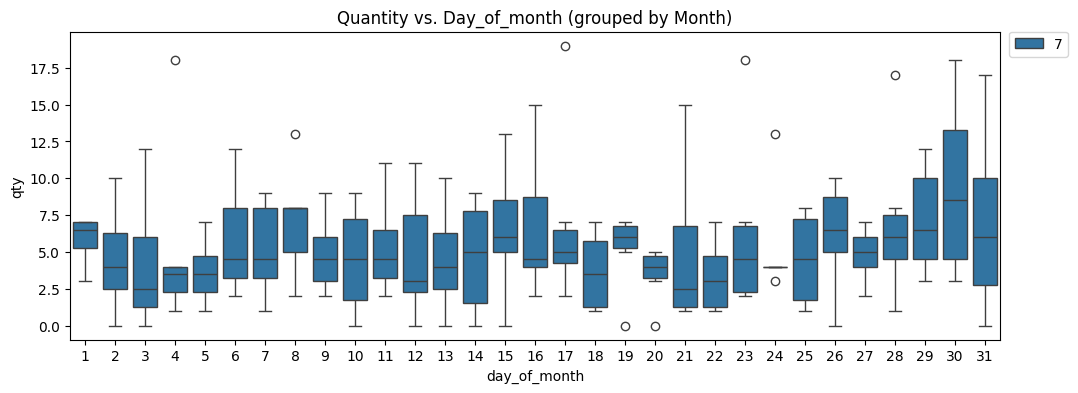

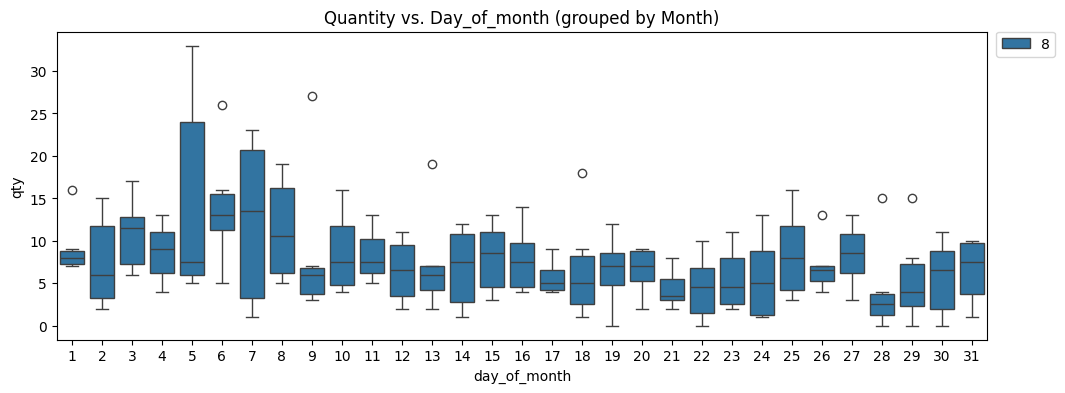

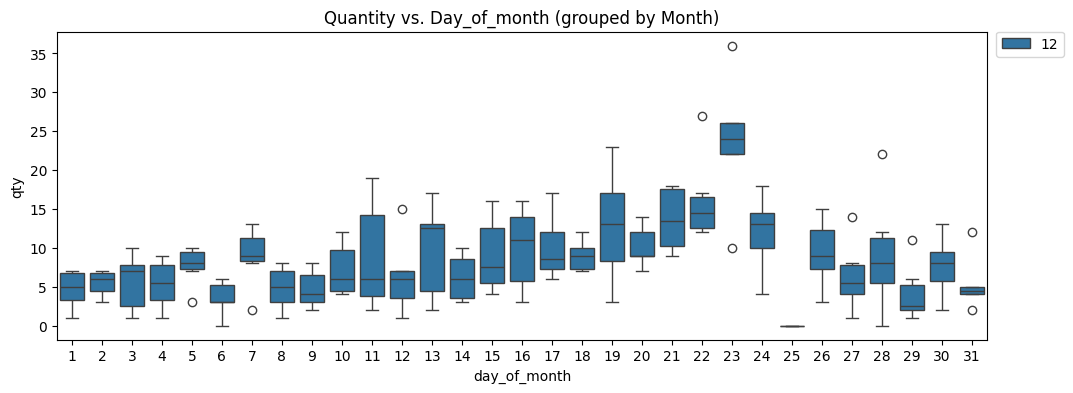

In [ ]:
# Boxplot for Quantity vs. day_of_month filtered by month
boxplot(sales_train[sales_train['month'] == 7], 'day_of_month', 'month')
boxplot(sales_train[sales_train['month'] == 8], 'day_of_month', 'month')
boxplot(sales_train[sales_train['month'] == 12], 'day_of_month', 'month')

## Feature Engineering
- Add feature for closed_day (Christmas and New Year's Day)
- Add seasonal features, in particular back-to-school and Christmas shopping seasons
- Add price momentum features based on the ratio of current and a past date's price
  - 'price_change_i' uses the price from i days before
  - Drop 'price' column since it's highly correlated with year, and indication of a change in price and how much it changed is likely more important that the price itself
- Add lag and rolling window features shifted at least a number of days equal to the number of day to forecast into the future (e.g. a forecast of up to 28 days into the future should set shift_day = 28)
  - 'lag_i' is the qty for the i-th day prior
  - 'lag_i_mean_j' is the rolling mean qty shifted back i days with a rolling window size j, and similarly for std/max/min

In [ ]:
sales_final = sales_processed.copy()

# Add feature for closed days (Christmas and New Year's Day)
christmas = (sales_final['month'] == 12) & (sales_final['day_of_month'] == 25)
new_years = (sales_final['month'] == 1) & (sales_final['day_of_month'] == 1)
sales_final['closed_day'] = (christmas | new_years).astype('int8')

# Add features for back to school season (weeks 31-32)
sales_final['back_to_school'] = ((sales_processed['week'] == 31) | (sales_processed['week'] == 32)).astype('int8')

# Add features for 2, 6, 10, and 14 days leading up to Christmas
for i in [2, 6, 10, 14]:
  sales_final[f'{i}d_to_christmas'] = ((sales_processed['month'] == 12) & (sales_processed['day_of_month'] >= 25-i) & (sales_processed['day_of_month'] < 25)).astype('int8')

In [ ]:
# Add price momentum features based on the ratio of current and a past date's price
shift_days = [30, 60, 90, 120, 180, 240, 365]

for shift in shift_days:
    col_name = f'price_change_{shift}'
    sales_final[col_name] = sales_final['base_price'] / sales_final['base_price'].shift(shift)

In [ ]:
shift_day = 28 # Number of days we'd like to forecast into the future

# Add lag features from shift_days to shift_days + 9 days ago
for i in range(shift_day, shift_day + 9):
  sales_final[f'lag_{i}'] = sales_final['qty'].shift(i)

# Add lag features from 76-85 days ago
for i in range(76, 86):
  sales_final[f'lag_{i}'] = sales_final['qty'].shift(i)

# Add lag features from 132-141 days ago
for i in range(132, 142):
  sales_final[f'lag_{i}'] = sales_final['qty'].shift(i)

# Add lag features from 356-365 days ago
for i in range(356, 366):
  sales_final[f'lag_{i}'] = sales_final['qty'].shift(i)

# Add rolling mean, std, max, and min features shifted 28 days
for i in [3, 7, 14, 30, 60, 90, 180]:
  sales_final[f'lag_{shift_day}_mean_{i}'] = sales_final['qty'].shift(shift_day).rolling(i).mean()
  sales_final[f'lag_{shift_day}_std_{i}'] = sales_final['qty'].shift(shift_day).rolling(i).std()
  sales_final[f'lag_{shift_day}_max_{i}'] = sales_final['qty'].shift(shift_day).rolling(i).max()
  sales_final[f'lag_{shift_day}_min_{i}'] = sales_final['qty'].shift(shift_day).rolling(i).min()

# Add rolling mean features shifted about 1 year
for i in [0, 7, 14]:
  for j in [3, 7]:
    sales_final[f'lag_{365 - i - j + 1}_mean_{j}'] = sales_final['qty'].shift(365 - i - j + 1).rolling(j).mean()

# Add rolling mean features shifted several weeks back
for i in [7, 14, 21]:
  sales_final[f'lag_{shift_day + i - 1}_mean_3'] = sales_final['qty'].shift(shift_day + i - 1).rolling(3).mean()
  for j in [7, 14, 30, 60]:
      sales_final[f'lag_{shift_day + i}_mean_{j}'] = sales_final['qty'].shift(shift_day + i).rolling(j).mean()

<ipython-input-37-111892062f65>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_final[f'lag_{shift_day + i - 1}_mean_3'] = sales_final['qty'].shift(shift_day + i - 1).rolling(3).mean()
<ipython-input-37-111892062f65>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_final[f'lag_{shift_day + i}_mean_{j}'] = sales_final['qty'].shift(shift_day + i).rolling(j).mean()
<ipython-input-37-111892062f65>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [ ]:
sales_final = sales_final.dropna()
sales_final = sales_final.drop('base_price', axis=1)

# Convert lag_i features to int8
for i in list(range(shift_day, shift_day + 8)) + list(range(358, 366)):
  col = f'lag_{i}'
  sales_final[col] = sales_final[col].astype('int8')

for i in [3, 7, 14, 30, 60, 90, 180]:
  col_max = f'lag_{shift_day}_max_{i}'
  col_min = f'lag_{shift_day}_min_{i}'
  sales_final[col_max] = sales_final[col_max].astype('int8')
  sales_final[col_min] = sales_final[col_min].astype('int8')

In [ ]:
sales_final.head()

,qty,year,month,week,day_of_week,day_of_month,week_of_month,is_weekend,is_holiday,closed_day,...,lag_41_mean_3,lag_42_mean_7,lag_42_mean_14,lag_42_mean_30,lag_42_mean_60,lag_48_mean_3,lag_49_mean_7,lag_49_mean_14,lag_49_mean_30,lag_49_mean_60
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,2019,1,1,1,1,1,0,1,1,...,4.666667,3.714286,4.571429,3.933333,4.200000,7.333333,5.428571,4.428571,3.733333,4.166667
2019-01-02,0.0,2019,1,1,2,2,1,0,0,0,...,3.666667,3.714286,4.785714,4.000000,4.150000,4.333333,5.857143,4.357143,3.733333,4.083333
2019-01-03,8.0,2019,1,1,3,3,1,0,0,0,...,2.000000,3.857143,4.428571,3.866667,4.083333,2.666667,5.000000,4.214286,3.700000,4.050000
2019-01-04,11.0,2019,1,1,4,4,1,0,0,0,...,2.333333,3.428571,4.571429,3.833333,4.116667,3.666667,5.714286,4.357143,3.833333,4.050000
2019-01-05,6.0,2019,1,1,5,5,1,1,0,0,...,3.333333,3.142857,4.357143,3.966667,4.166667,4.000000,5.571429,4.714286,3.900000,4.133333


In [ ]:
sales_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2344 entries, 2019-01-01 to 2025-06-01
Columns: 110 entries, qty to lag_49_mean_60
dtypes: float64(66), int32(1), int8(43)
memory usage: 1.3 MB


In [ ]:
#@title Train-Test Split

mask = sales_final.index < '2024-06-03' # Split between June 2 and 3, 2024
train = sales_final[mask]
test = sales_final[~mask]

In [ ]:
print("Training set dim:", train.shape)
print("Test set dim:", test.shape)

Training set dim: (1980, 110)
Test set dim: (364, 110)


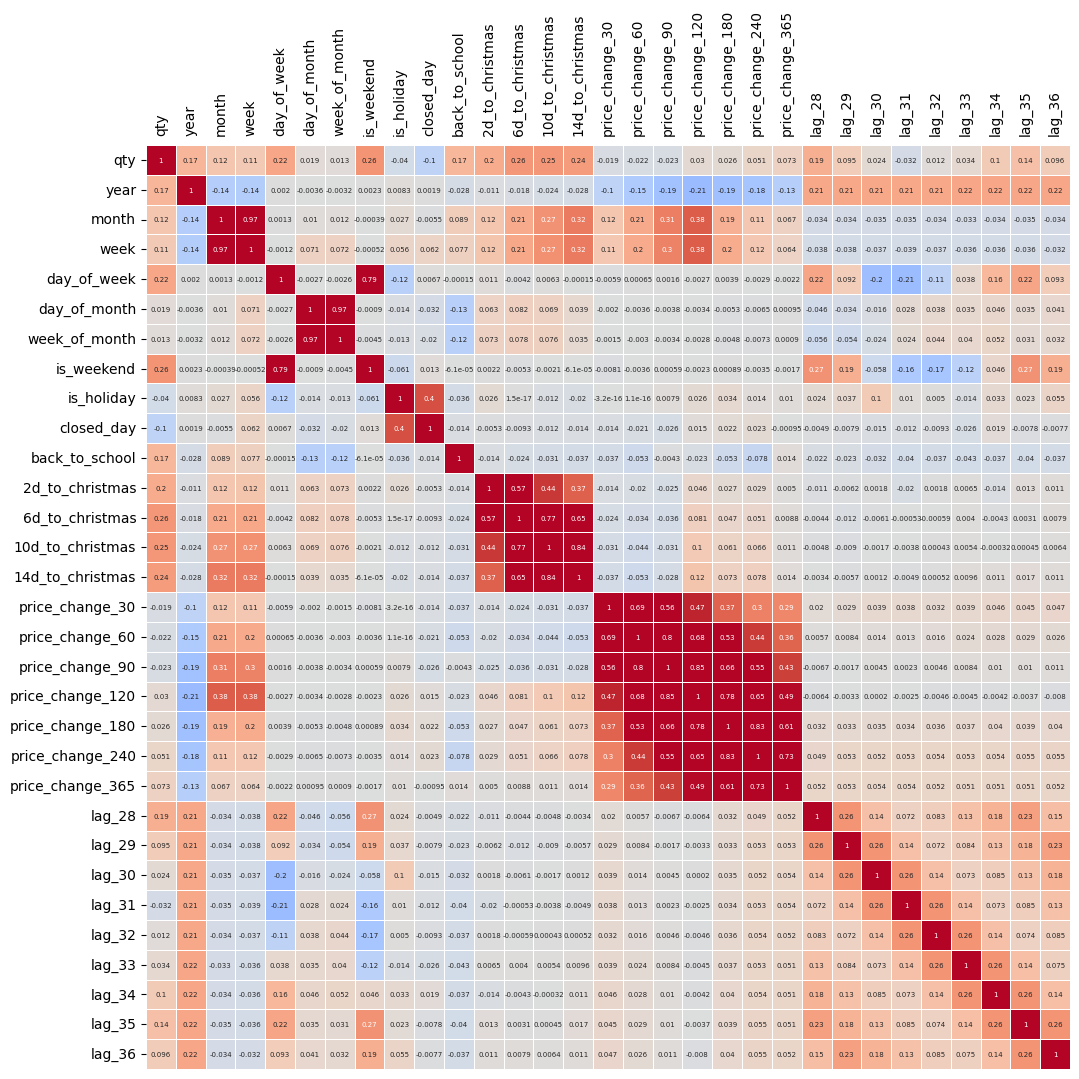

In [ ]:
#@title Correlation Matrix excluding rolling window features

train_corr = train.corr()

plt.figure(figsize=(12, 12))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
heatmap = sns.heatmap(pd.DataFrame(train_corr.iloc[0:31, 0:31]), vmin=-0.5, vmax=0.5, annot=True, annot_kws={"fontsize":5}, linewidth=.5, square=True, cmap="coolwarm", cbar=False)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


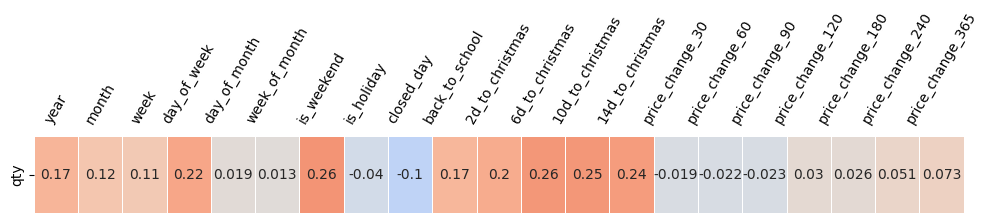

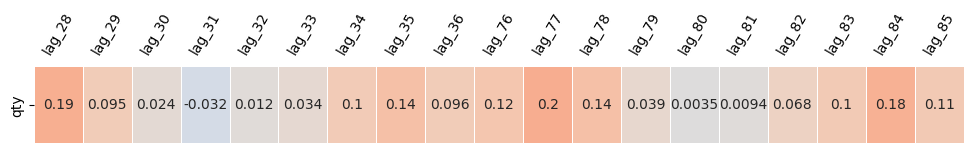

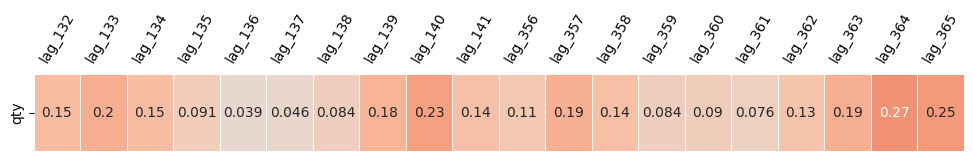

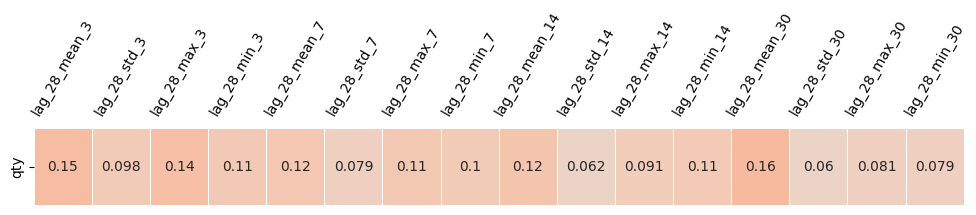

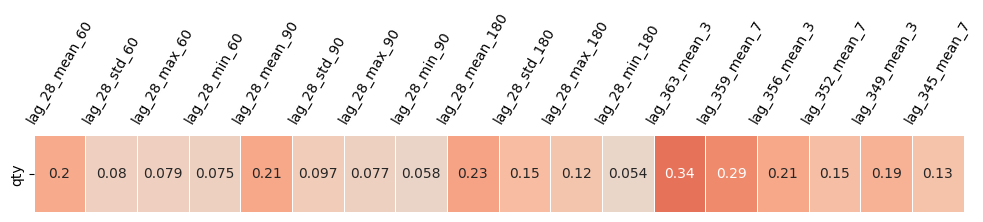

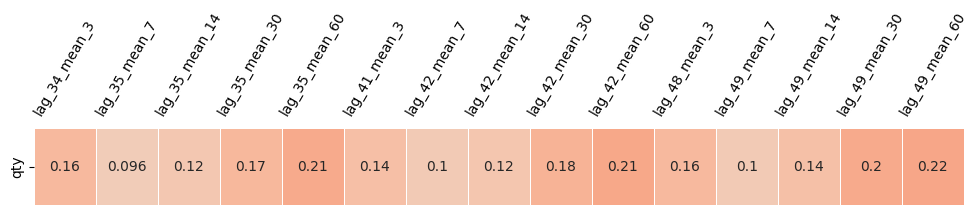

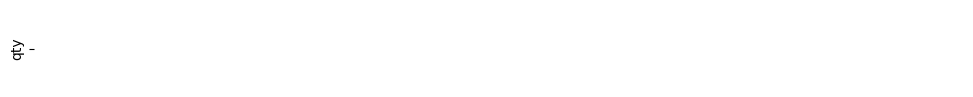

In [ ]:
#@title Correlation with Target

end_idxs = [22, 41, 61, 77, 95, 110, 130]
start_idx = 1

for end_idx in end_idxs:
  plt.figure(figsize=(12, 1))
  plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top=False, labeltop=True)
  heatmap = sns.heatmap(pd.DataFrame(train_corr.iloc[0, start_idx:end_idx]).T, vmin=-0.5, vmax=0.5, annot=True, linewidth=.5, cmap="coolwarm", cbar=False)
  plt.xticks(rotation=60)
  start_idx = end_idx

## Export DataFrames to CSV Files

In [ ]:
# Export dataframe
sales_final.to_csv(f'{path}full.csv', index=True, index_label='date')
train.to_csv(f'{path}train.csv', index=True, index_label='date')
test.to_csv(f'{path}test.csv', index=True, index_label='date')